## **Importing Libraries**

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding

import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

## **Loading Dataset**

In [ ]:
#Reading the data set
df = pd.read_csv("/content/drive/My Drive/offensiveMemes.csv")

In [ ]:
df.head()

,image_name,text_ocr,text_corrected,offensive
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_offensive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_offensive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive


In [ ]:
#dropping unwanted axis
df.drop(["image_name", "text_ocr"], 
          axis=1,
          inplace=True)

In [ ]:
#Removing the not_offensive rows
df=df[(df['offensive'] == 'hateful_offensive') | (df['offensive'] == 'very_offensive') | (df['offensive'] == 'slight')]

In [ ]:
df

,text_corrected,offensive
3,10 Year Challenge - Sweet Dee Edition,very_offensive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive
5,"1998: ""Don't get in car with strangers"" 2008: ...",slight
8,Fornite died in 10 months but Minecraft never ...,slight
9,FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...,slight
...,...,...
6982,I STILL KNOW NOTHING! 2017,very_offensive
6983,"Create a hashtag for this... ""NO TIME TO EXPLA...",slight
6984,YOU'RE THE BEST AROUND. NOTHING'S EVER GONNA K...,hateful_offensive
6987,Tuesday is Mardi Gras Wednesday is Valentine's...,very_offensive


# Cleaning Dataset

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

import pandas as pd
import re
df['text_corrected'] = df.fillna({'text_corrected':''})
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text
# apply the above function to df['text']
df['text_corrected'] = df['text_corrected'].map(lambda x: clean_text(x))

In [ ]:
df.isnull().values.any()

False

## **Class Distribution**

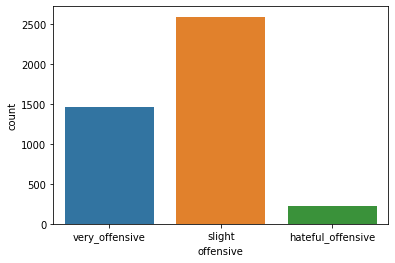

In [ ]:
import seaborn as sns

sns.countplot(x='offensive', data=df)

In [ ]:
X = df['text_corrected']
y = df['offensive']
categories = ('very_offensive','slight', 'hateful_offensive')
y = np.array(y)

In [ ]:
print(y.shape)
print(X.shape)

(4279,)
(4279,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

## **Loading Glove Embeddings**

In [ ]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
f = open('glove.6B.300d.txt')
embeddings_dictionary = dict()
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

In [ ]:
#Preaping embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 15
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8091


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
## Create model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(3, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [ ]:
history = model_glove.fit(X_train, y_train, batch_size=2048, epochs=7, verbose=1, validation_split=0.45)

Train on 1882 samples, validate on 1541 samples
Epoch 1/7
1882/1882 [==============================] - 0s 207us/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 1.2845 - val_accuracy: 0.7872
Epoch 2/7
1882/1882 [==============================] - 0s 207us/step - loss: 0.0103 - accuracy: 0.9957 - val_loss: 1.2854 - val_accuracy: 0.7865
Epoch 3/7
1882/1882 [==============================] - 0s 205us/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 1.2864 - val_accuracy: 0.7872
Epoch 4/7
1882/1882 [==============================] - 0s 206us/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 1.2873 - val_accuracy: 0.7872
Epoch 5/7
1882/1882 [==============================] - 0s 217us/step - loss: 0.0104 - accuracy: 0.9957 - val_loss: 1.2882 - val_accuracy: 0.7872
Epoch 6/7
1882/1882 [==============================] - 0s 206us/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 1.2891 - val_accuracy: 0.7872
Epoch 7/7
1882/1882 [==============================] - 0s 206us/step - loss: 0.012